In [78]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import _add_deltas, split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import add_era_bucket, add_history_coverage, cast_feature_dtypes, pull_data, pull_projections
from modeling import calculate_productivity_score, add_per_year_features, calculate_growths, calculate_years_since_peak, add_player_tier, add_pitcher_role_flags, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
AGG_YEARS = 3
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.33
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.32

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [2]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Additional feature engineering
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
# Ensure proper data types for modeling
batting_df = (
    batting_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_agg_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(calculate_years_since_peak)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(add_per_year_features, agg_years=AGG_YEARS, sum_cols=["G", "AB", "R", "H", "HR", "SB", "BB", "SO", "WAR"],)
    .pipe(calculate_growths, agg_years=AGG_YEARS)
    .pipe(add_player_tier, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)
pitching_df = (
    pitching_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_agg_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(calculate_years_since_peak)
    .pipe(add_pitcher_role_flags)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(add_per_year_features, agg_years=AGG_YEARS, sum_cols=["G", "GS", "IP", "W", "SO", "BB", "HR", "ER", "WAR"],)
    .pipe(calculate_growths, agg_years=AGG_YEARS)
    .pipe(add_player_tier, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with 0 future fantasy points (would not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

Pulling data for year: 2005
Pulling data for year: 2006
Pulling data for year: 2007
Pulling data for year: 2008
Pulling data for year: 2009
Pulling data for year: 2010
Pulling data for year: 2011
Pulling data for year: 2012
Pulling data for year: 2013
Pulling data for year: 2014
Pulling data for year: 2015
Pulling data for year: 2016
Pulling data for year: 2017
Pulling data for year: 2018
Pulling data for year: 2019
Pulling data for year: 2020
Pulling data for year: 2021
Pulling data for year: 2022
Pulling data for year: 2023
Pulling data for year: 2024
Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully.
Data pull complete.


# Pulling FantasyPros Projection Data

In [5]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [6]:
display(batting_projections.head())

first_name last_name Team    Positions  projected_fantasy_points
0     shohei    ohtani  LAD        SP,DH                      1777
1      aaron     judge  NYY  LF,CF,RF,DH                      1748
2      bobby      witt   KC           SS                      1558
3       juan      soto  NYM        LF,RF                      1652
4     ronald     acuna  ATL           RF                      1534

# Defining Baseline Model

## Creating baseline batting predictions

In [7]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 271.057 | MAE: 210.588 | R^2: 0.628


In [8]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  prediction_diff  absolute_diff  Season  Age  fantasy_points
624      Shohei Ohtani                 2143.0               1823.445923      -319.554077     319.554077    2023   28            1635
1200     J.D. Martinez                 1711.0               1761.067383        50.067383      50.067383    2017   29            1354
1436   Freddie Freeman                 1845.0               1738.741699      -106.258301     106.258301    2022   32            1648
126      Albert Pujols                 1739.0               1733.714600        -5.285400       5.285400    2007   27            1628
116          Juan Soto                 1814.0               1705.984009      -108.015991     108.015991    2024   25            1799
...                ...                    ...                       ...              ...            ...     ...  ...             ...
188         Sandy Leon                  105.0                111.296448         6.296448       6.296448    2019   30             251
551    Grayson Greiner                   89.0                105.362640        16.362640      16.362640    2019   26             297
1172   Patrick Mazeika                   84.0                105.289665        21.289665      21.289665    2021   27             106
744   Michael Martinez                  132.0                 95.523285       -36.476715      36.476715    2011   28             333
535        Craig Tatum                  110.0                 86.830574       -23.169426      23.169426    2010   27             188

[1590 rows x 8 columns]

# Building Final Model

In [9]:
MAX_DEPTH_CHOICES = [4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.00),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(12.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(3.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-3), np.log(2.0)),
}

# Batting Predictions

In [10]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=60,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 60/60 [02:22<00:00,  2.38s/trial, best loss: 262.43721831182796]
Best Parameters: {'learning_rate': 0.1924610329486812, 'max_depth': 4, 'subsample': 0.9549292783806261, 'colsample_bytree': 0.8821672278810795, 'min_child_weight': 1.0483144321368705, 'reg_lambda': 2.186414330740639, 'reg_alpha': 0.00179766878510381, 'gamma': 0.0017344905673841483}
[Best trial @ val] optimized=rmse | RMSE=262.437 | MAE=202.071 | ASYM=86458.927


In [11]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 34
[Val] RMSE: 262.437 | MAE: 202.071 | R^2: 0.618 | ASYM: 86458.927
[Test] RMSE: 267.983 | MAE: 208.731 | R^2: 0.637 | ASYM: 88076.292


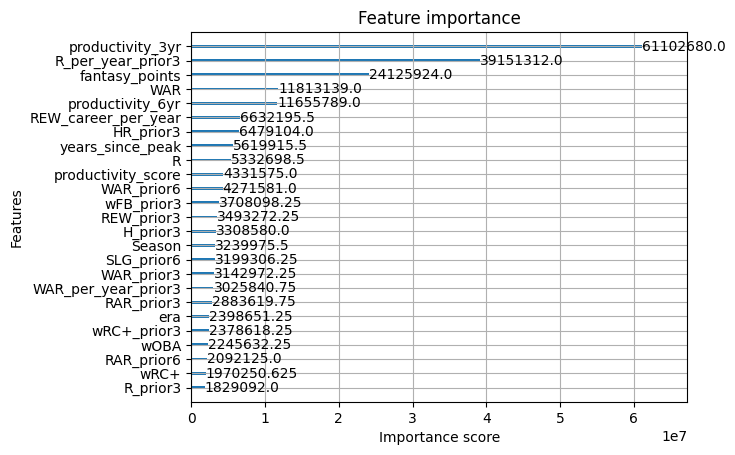

In [12]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [13]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  prediction_diff  absolute_diff  Season  Age  fantasy_points
184     Alex Rodriguez                 2062.0               1738.810181      -323.189819     323.189819    2006   30            1648
116          Juan Soto                 1814.0               1730.556885       -83.443115      83.443115    2024   25            1799
1436   Freddie Freeman                 1845.0               1720.774902      -124.225098     124.225098    2022   32            1648
1052    Hanley Ramirez                 1806.0               1687.178833      -118.821167     118.821167    2006   22            1607
739     Miguel Cabrera                 1762.0               1670.384888       -91.615112      91.615112    2011   28            1718
...                ...                    ...                       ...              ...            ...     ...  ...             ...
535        Craig Tatum                  110.0                127.352898        17.352898      17.352898    2010   27             188
188         Sandy Leon                  105.0                123.642319        18.642319      18.642319    2019   30             251
1172   Patrick Mazeika                   84.0                122.242447        38.242447      38.242447    2021   27             106
744   Michael Martinez                  132.0                120.074608       -11.925392      11.925392    2011   28             333
553        Roman Quinn                  208.0                 98.326950      -109.673050     109.673050    2019   26             240

[1590 rows x 8 columns]

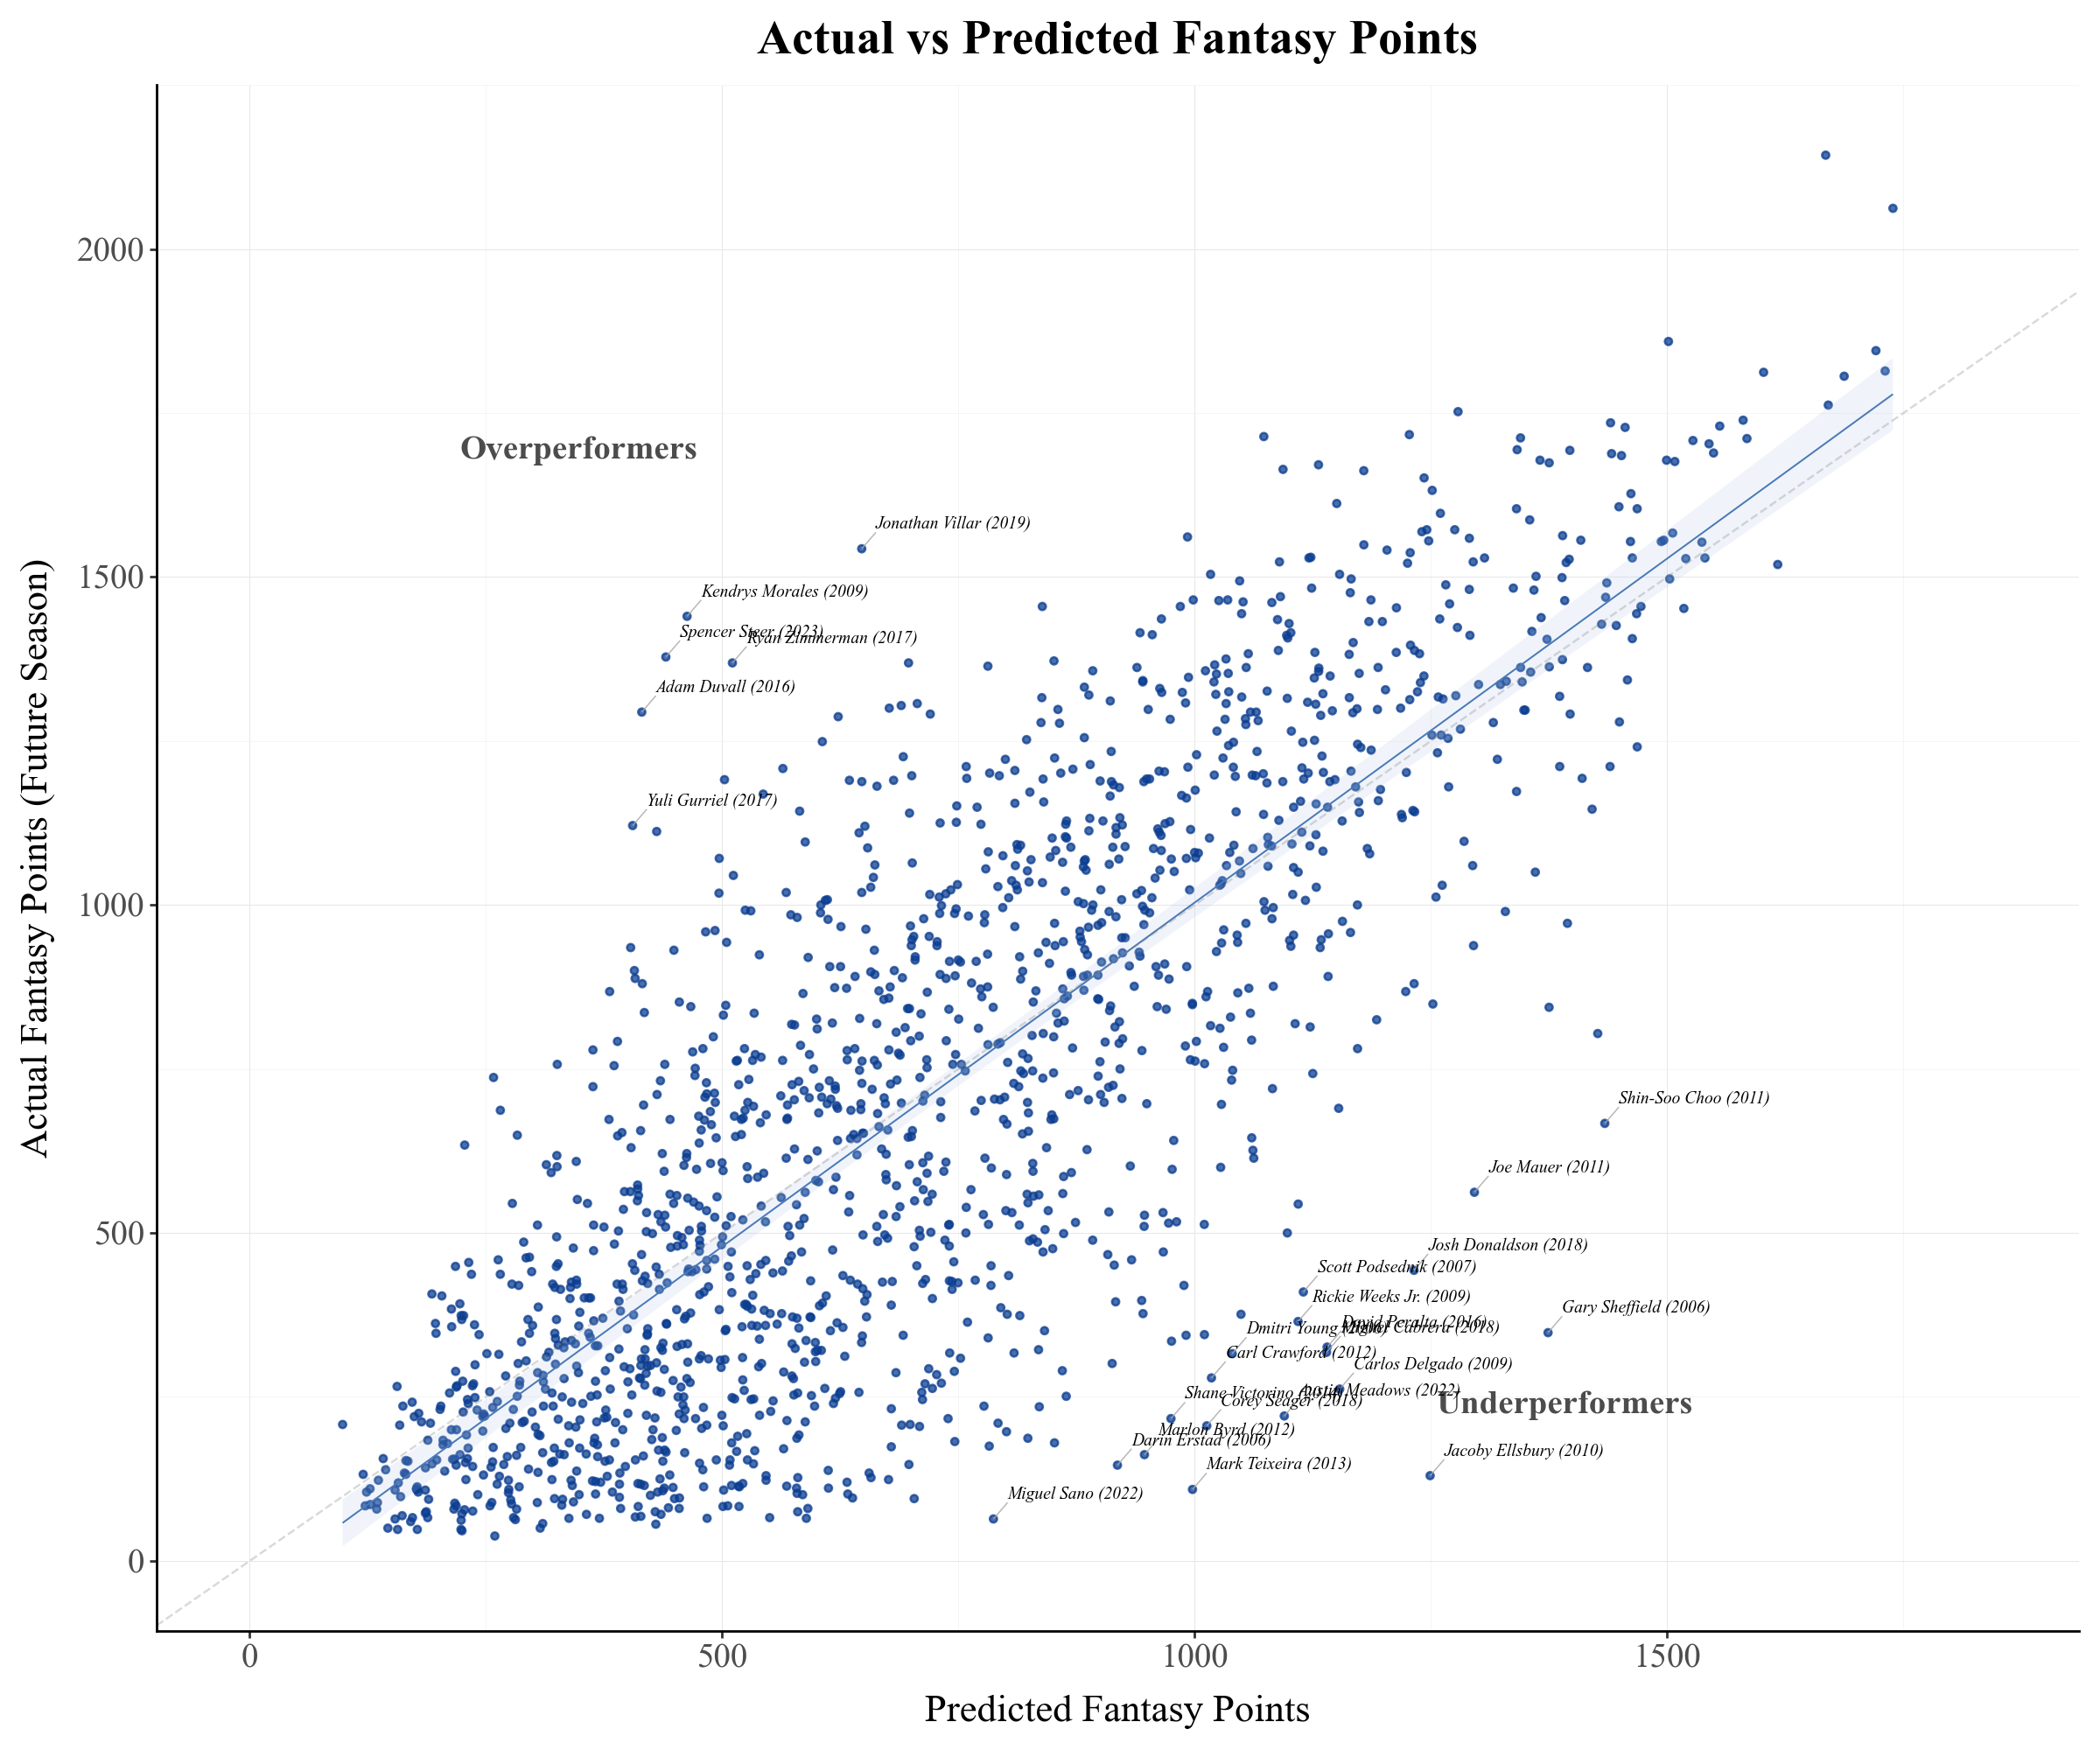

In [14]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

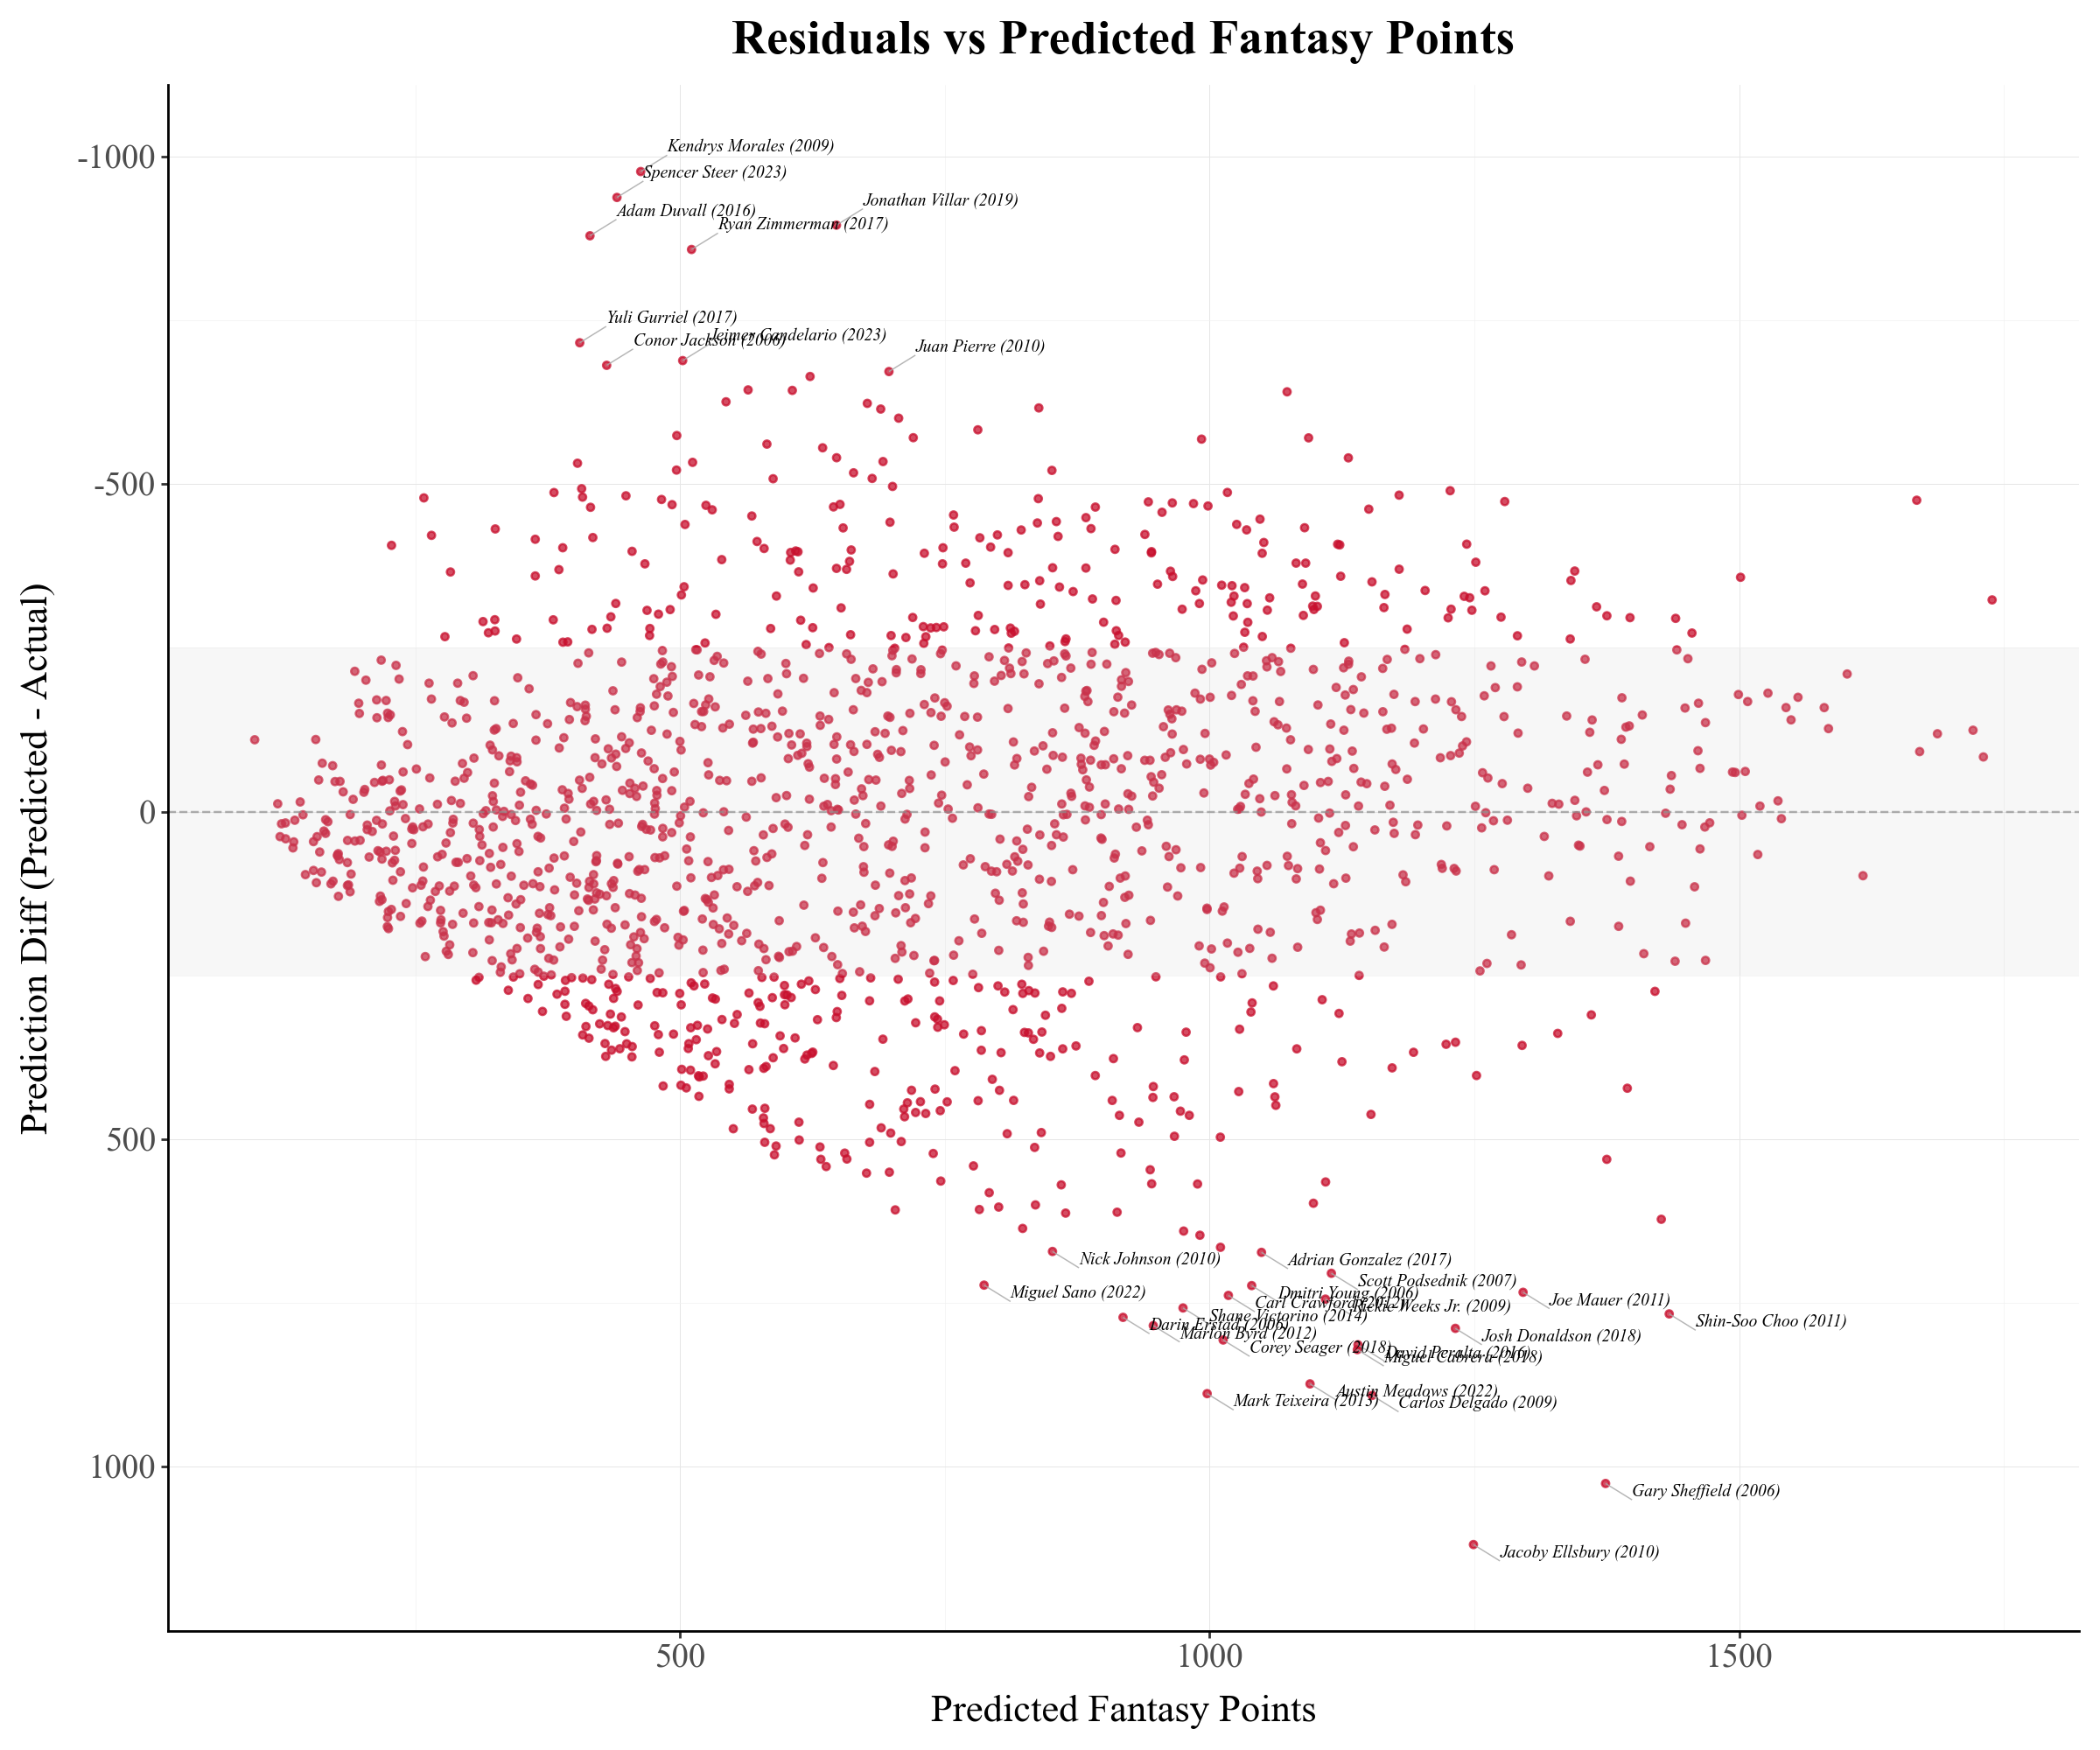

In [15]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

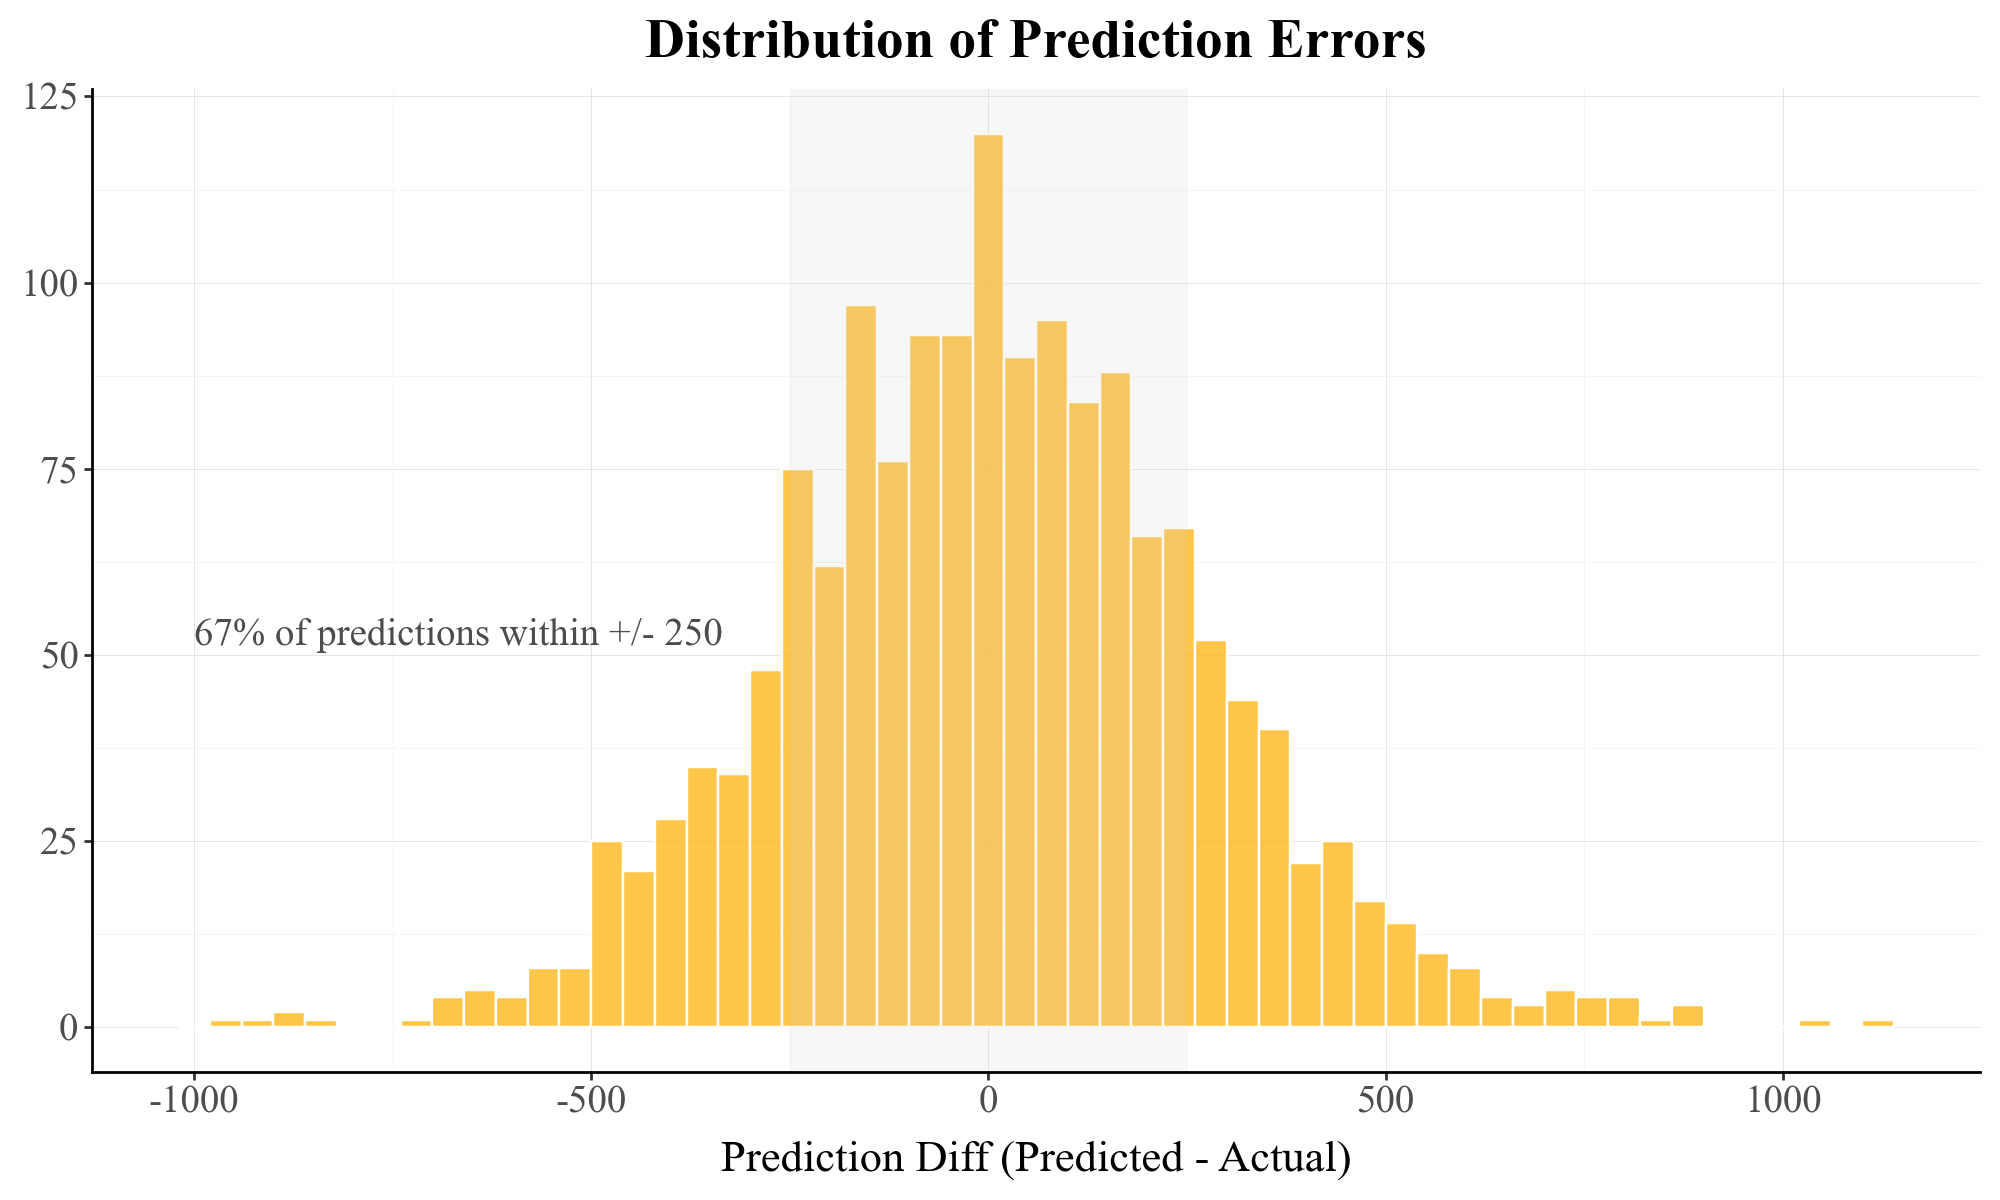

In [16]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

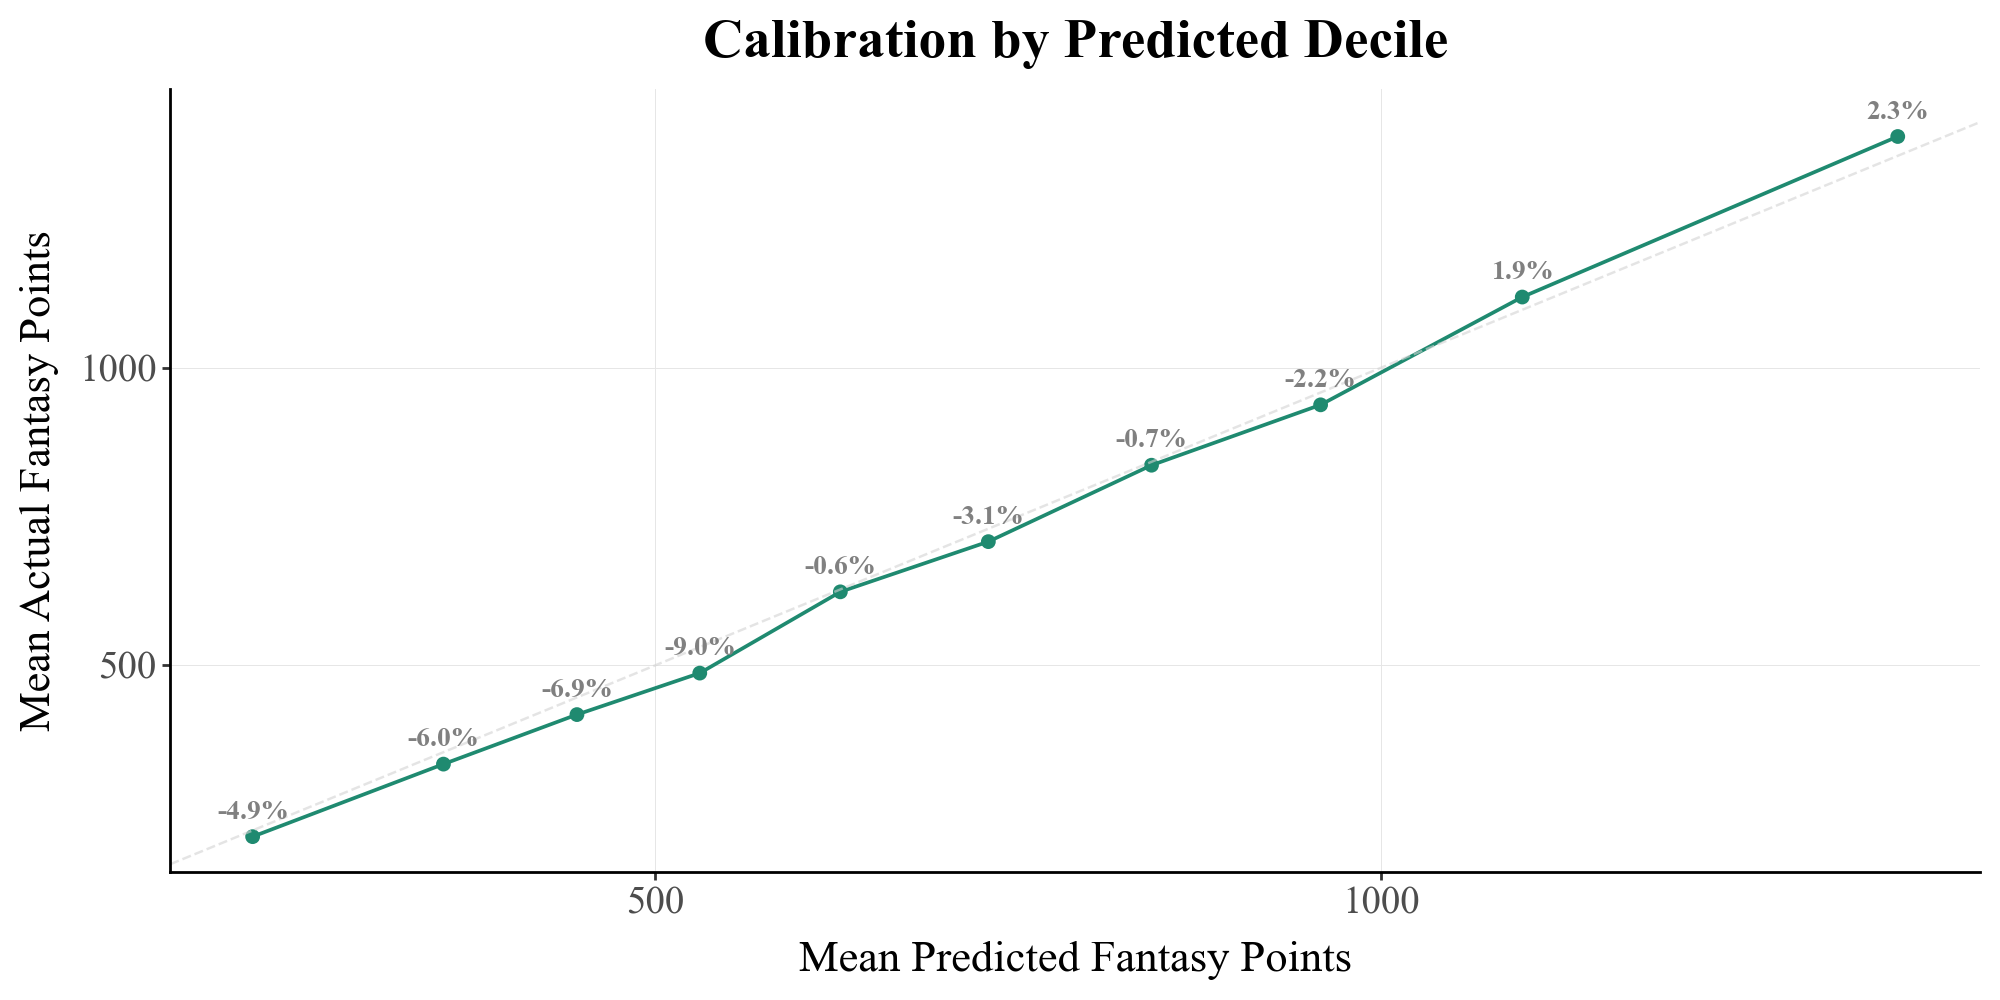

In [17]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [18]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 175.299 | MAE: 128.636 | R^2: 0.614


In [19]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  prediction_diff  absolute_diff  Season  Age  fantasy_points
361   Justin Verlander                 1167.3               1278.145996       110.845996     110.845996    2009   26          1346.0
1124        Chris Sale                 1444.3               1216.801392      -227.498608     227.498608    2016   27          1210.6
1274     Jose Quintana                 1010.0               1205.594360       195.594360     195.594360    2015   26           963.3
968         Chris Sale                 1274.6               1194.235352       -80.364648      80.364648    2014   25          1080.0
347          Cliff Lee                 1309.6               1145.102051      -164.497949     164.497949    2010   31          1026.3
...                ...                    ...                       ...              ...            ...     ...  ...             ...
1381      Adam Kolarek                  105.0                 76.212410       -28.787590      28.787590    2019   30           270.0
1072   Ryan Feierabend                   98.6                 67.868225       -30.731775      30.731775    2007   21           101.3
1347       Cory Abbott                  155.3                 66.504555       -88.795445      88.795445    2022   26           195.0
553       Lewis Thorpe                   45.3                 58.865185        13.565185      13.565185    2019   23           132.6
1524        Brad Mills                   53.3                 50.504116        -2.795884       2.795884    2010   25            83.3

[1525 rows x 8 columns]

# Pitching Predictions

In [20]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=60,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 60/60 [02:24<00:00,  2.41s/trial, best loss: 162.4149120234164] 
Best Parameters: {'learning_rate': 0.12711355649632675, 'max_depth': 4, 'subsample': 0.8453770292289962, 'colsample_bytree': 0.8531193007800919, 'min_child_weight': 2.9008986819121834, 'reg_lambda': 8.866958850567636, 'reg_alpha': 2.3044924538267093, 'gamma': 0.015592935373453496}
[Best trial @ val] optimized=rmse | RMSE=162.415 | MAE=121.361 | ASYM=32763.261


In [21]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 85
[Val] RMSE: 162.415 | MAE: 121.361 | R^2: 0.679 | ASYM: 32763.261
[Test] RMSE: 171.006 | MAE: 126.337 | R^2: 0.632 | ASYM: 36409.069


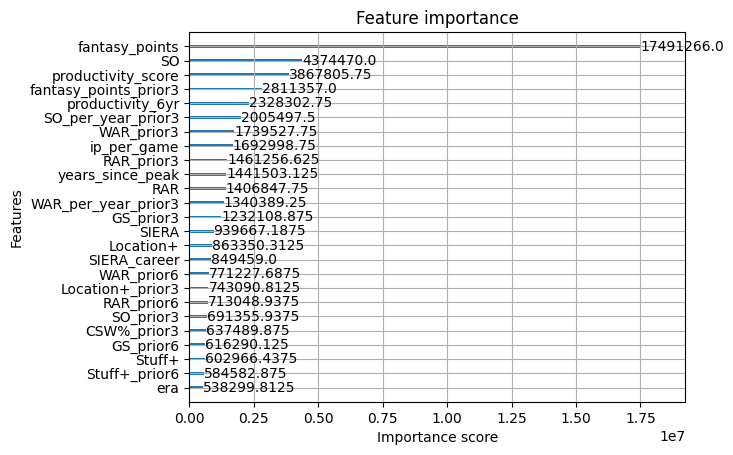

In [22]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [23]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  prediction_diff  absolute_diff  Season  Age  fantasy_points
1124           Chris Sale                 1444.3               1276.360107      -167.939893     167.939893    2016   27          1210.6
313       Felix Hernandez                 1193.0               1266.334106        73.334106      73.334106    2011   25          1165.6
361      Justin Verlander                 1167.3               1234.549194        67.249194      67.249194    2009   26          1346.0
92       Justin Verlander                 1482.0               1228.244141      -253.755859     253.755859    2018   35          1412.0
1274        Jose Quintana                 1010.0               1154.712646       144.712646     144.712646    2015   26           963.3
...                   ...                    ...                       ...              ...            ...     ...  ...             ...
1381         Adam Kolarek                  105.0                 68.177498       -36.822502      36.822502    2019   30           270.0
206   Austin Bibens-Dirkx                  151.0                 68.162033       -82.837967      82.837967    2017   32           238.3
553          Lewis Thorpe                   45.3                 62.959904        17.659904      17.659904    2019   23           132.6
281         Tanner Rainey                  143.3                 56.603420       -86.696580      86.696580    2019   26           313.3
44        Stefan Crichton                  136.0                 45.257477       -90.742523      90.742523    2019   27           158.3

[1525 rows x 8 columns]

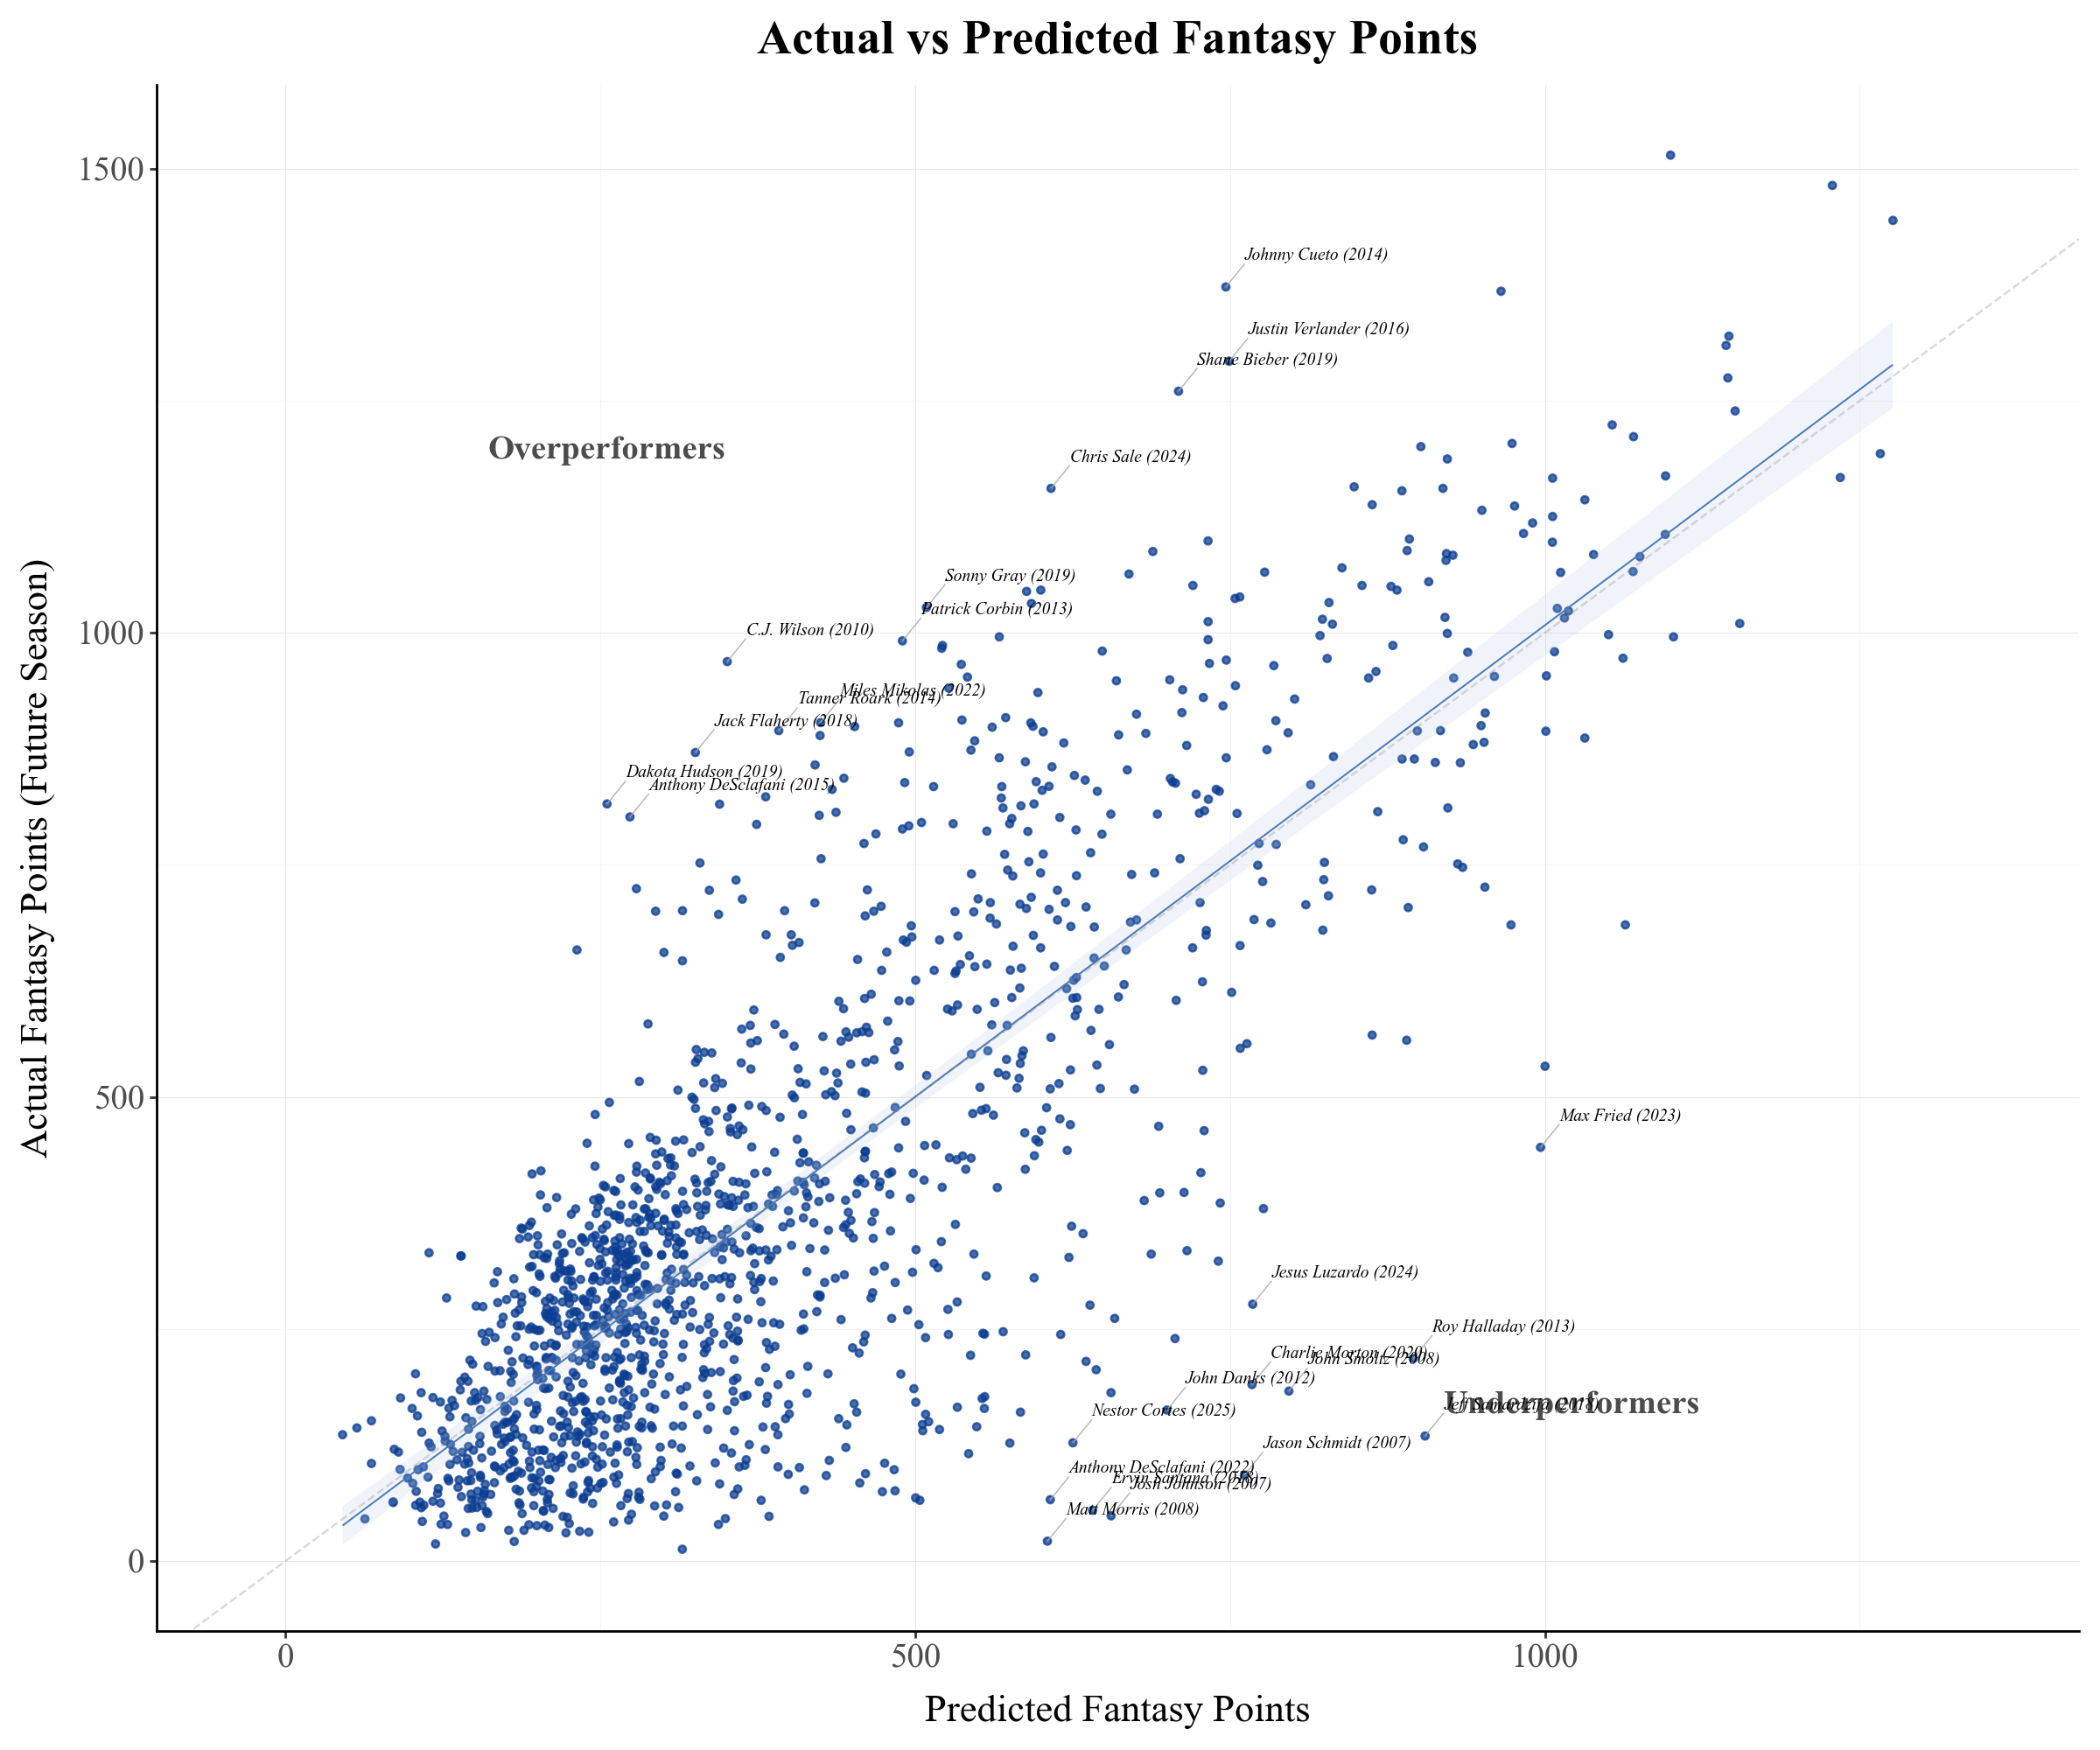

In [24]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

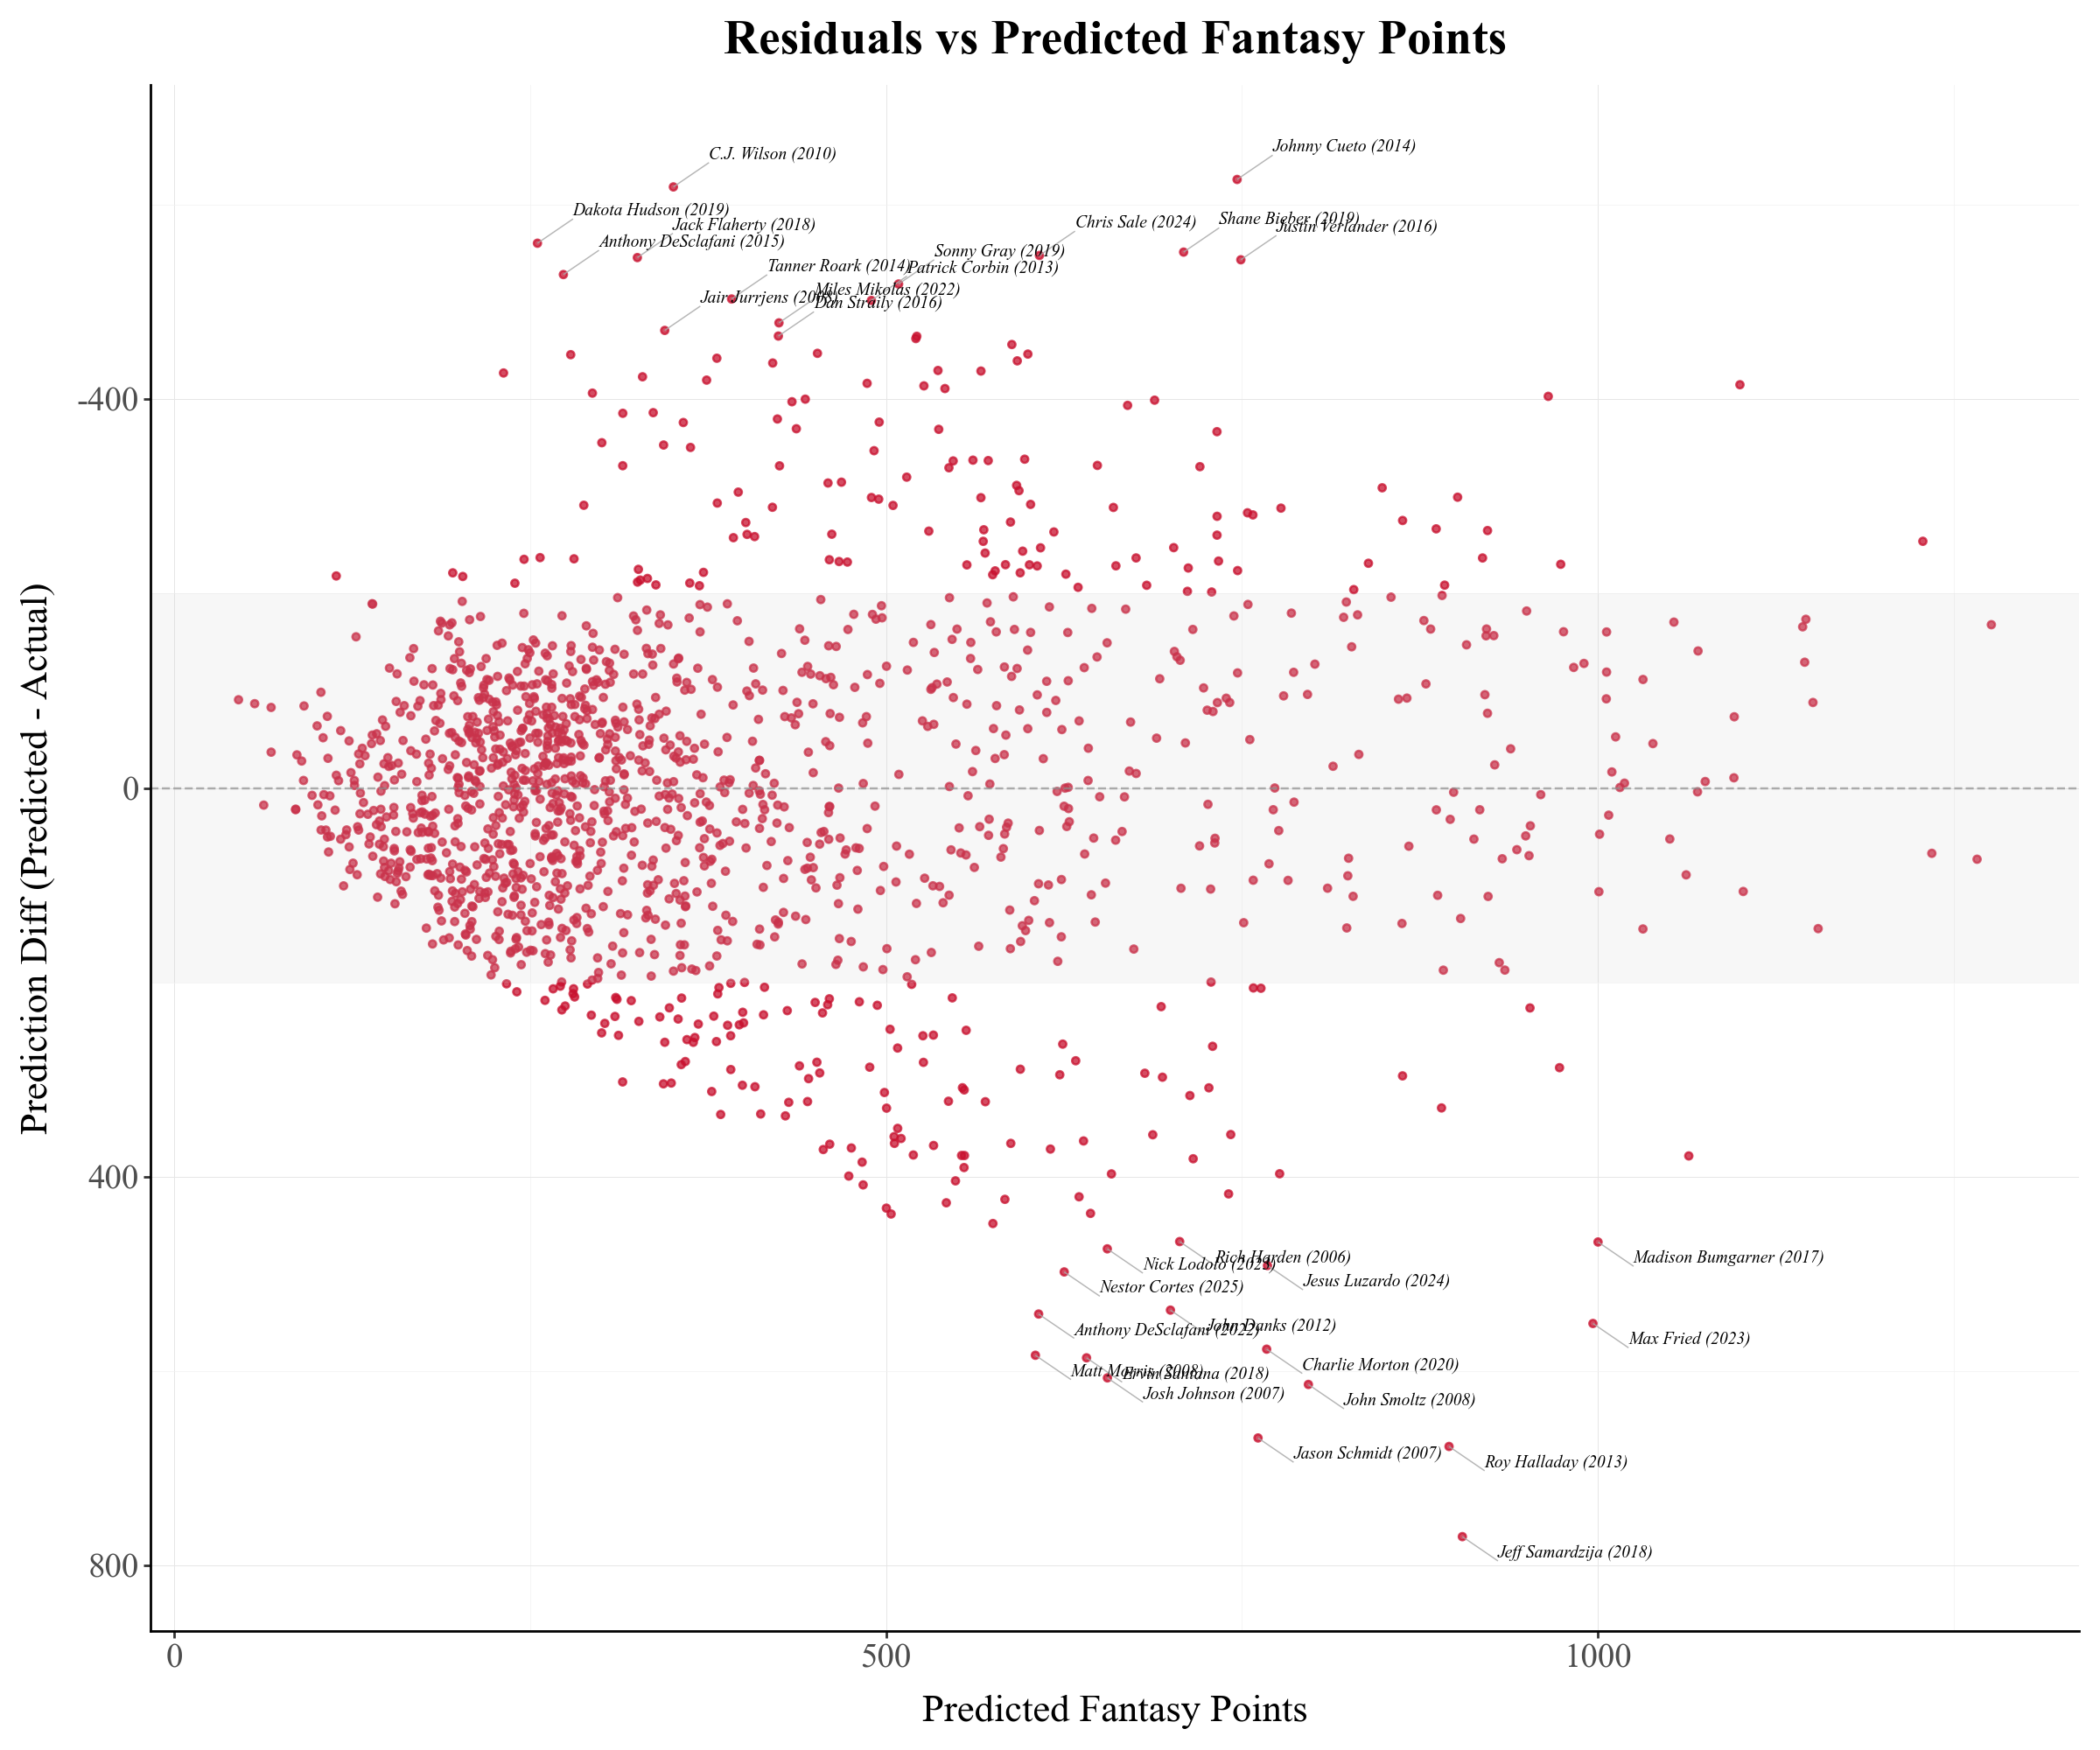

In [25]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

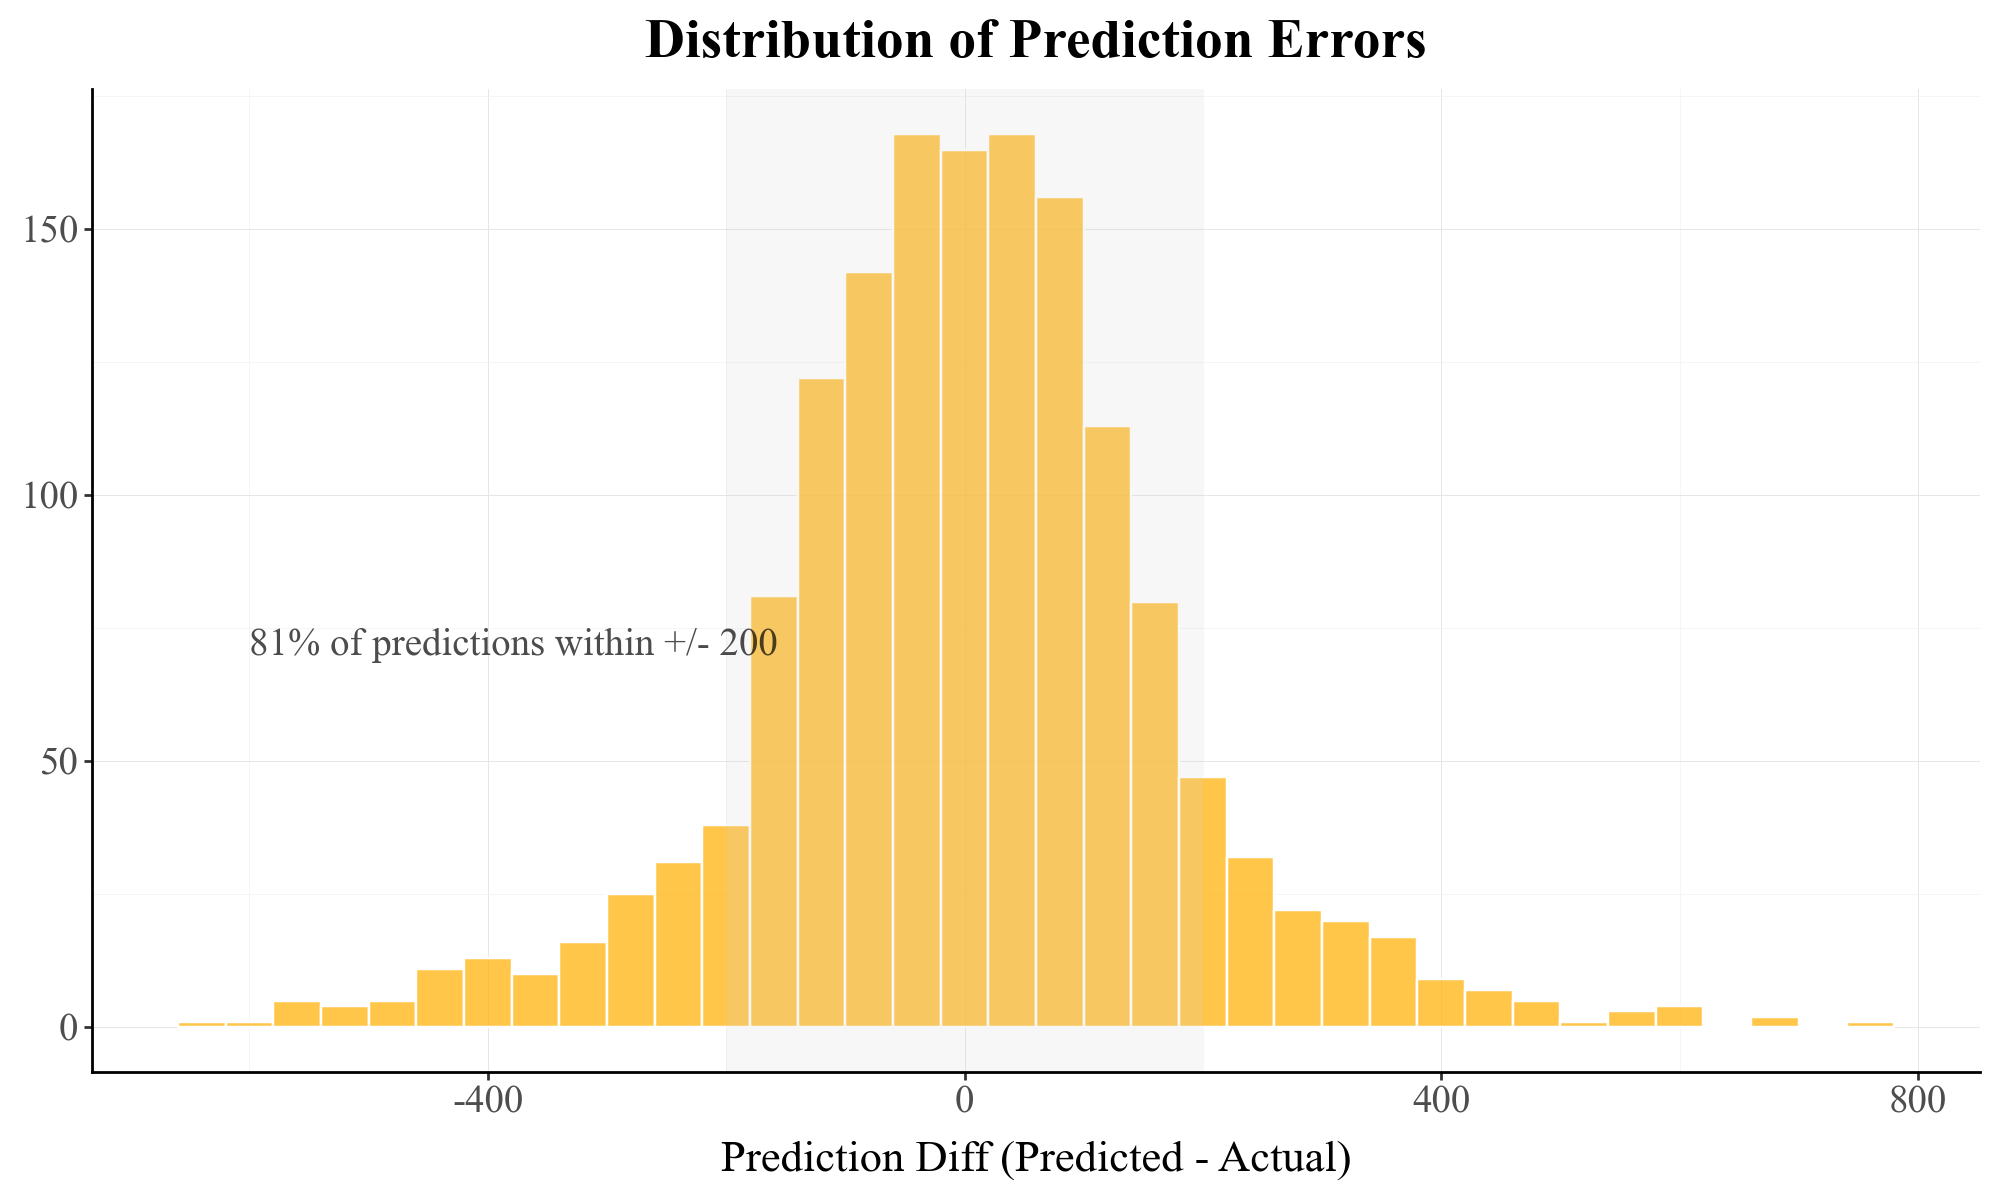

In [26]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=200,
    binwidth=40,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

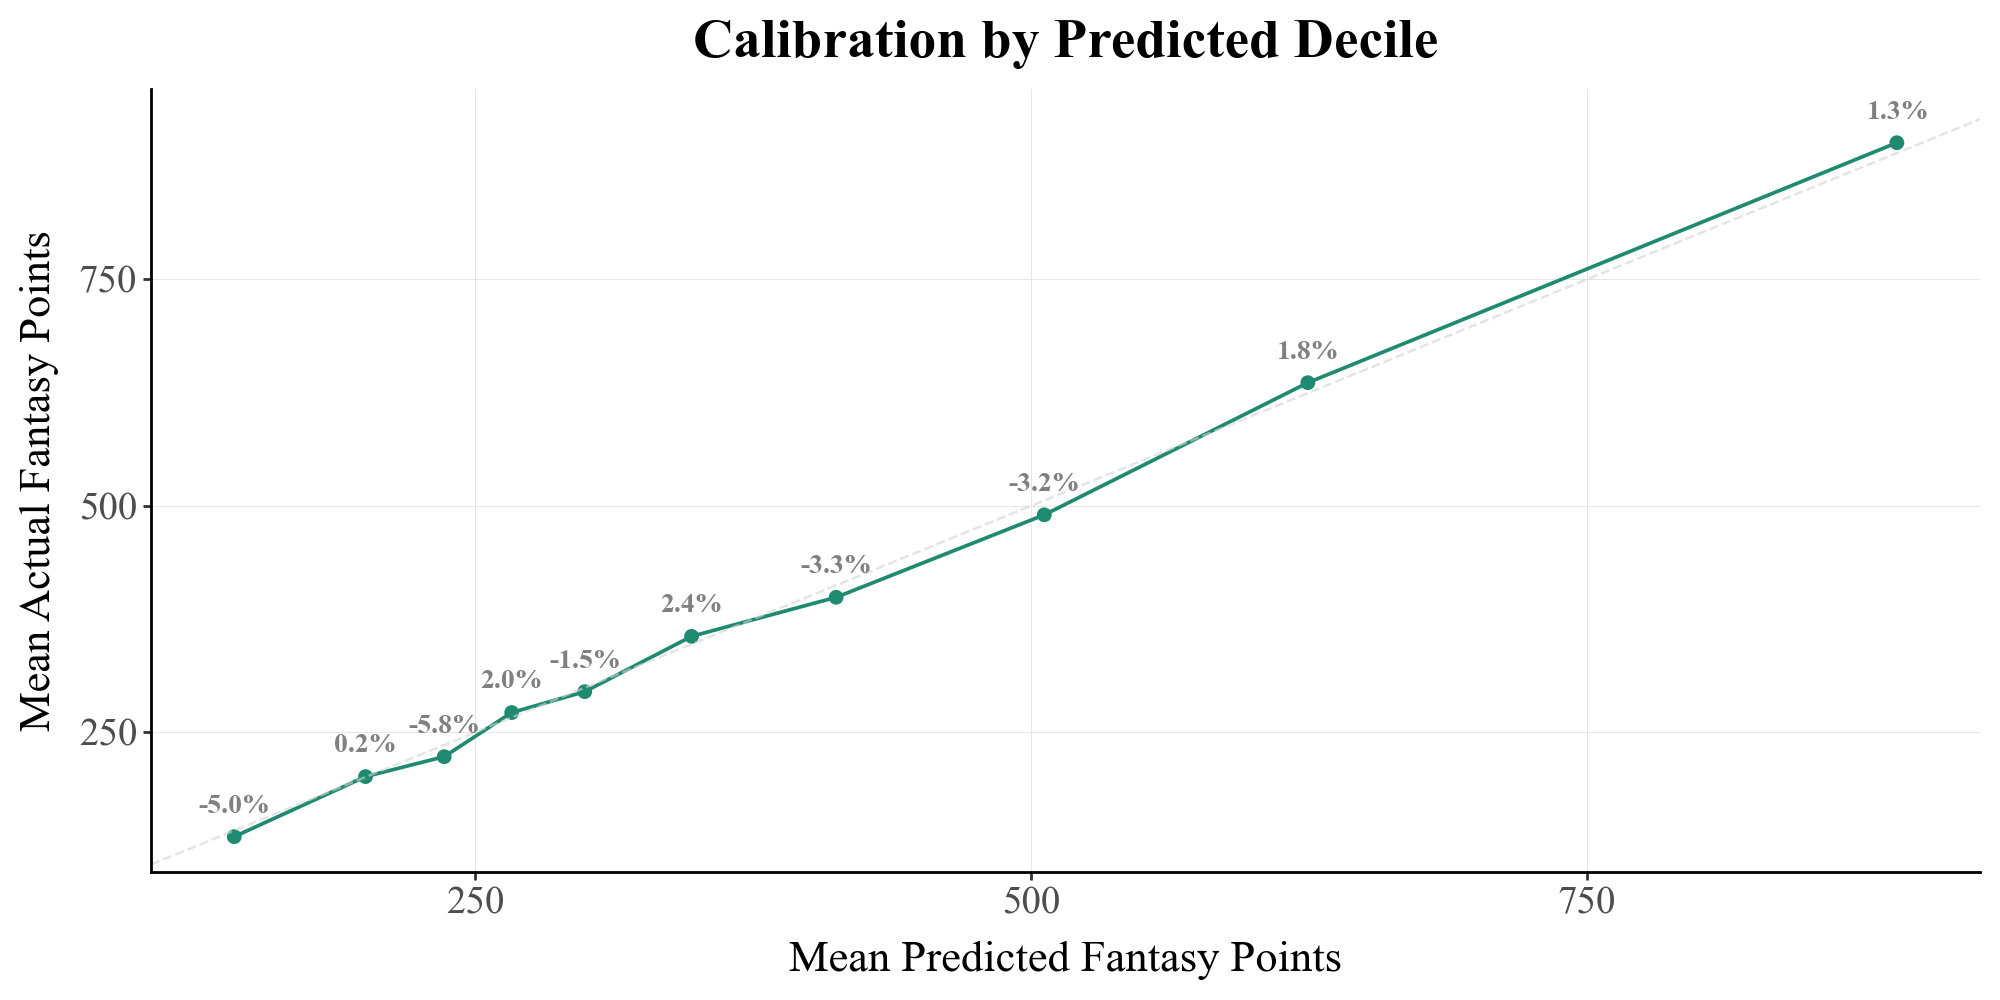

In [27]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [28]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [29]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [30]:
display(batting_pred)

IDfg  Season               Name  Age  ...  AB_growth_recent  G_growth_recent  player_tier_recent  fantasy_points_pred
10491  20123    2025          Juan Soto   26  ...          3.333333         0.333333                star          1541.886841
9180   15640    2025        Aaron Judge   33  ...              52.0        13.333333                star          1489.046143
10328  19755    2025      Shohei Ohtani   30  ...         29.666667         7.333333                star          1483.668945
9457   16478    2025     Kyle Schwarber   32  ...         16.666667         4.666667           above_avg          1451.396851
8456   13510    2025       Jose Ramirez   32  ...             -15.0         0.666667                star          1441.297485
...      ...     ...                ...  ...  ...               ...              ...                 ...                  ...
11266  29487    2025         Blake Dunn   26  ...             -26.0            -19.0         replacement           139.017136
11367  31665    2025      Alex Freeland   23  ...               0.0              0.0         replacement           138.417084
10838  22842    2025  Alexander Canario   25  ...             130.0             51.0         replacement           135.845917
10623  21496    2025  Brandon Lockridge   28  ...             -12.0            -12.0         replacement           129.764877
10851  23296    2025        Jacob Amaya   26  ...         18.333333        15.333333         replacement           118.131714

[537 rows x 204 columns]

In [31]:
display(pitching_pred)

IDfg  Season              Name  Age   G  ...  G_growth_recent  IP_growth_recent  GS_growth_recent  player_tier_recent  fantasy_points_pred
6616   10310    2025      Zack Wheeler   35  24  ...        -5.333333             -31.2         -5.333333                star           911.389221
9266   17295    2025    Framber Valdez   31  31  ...              1.0               3.3               1.0                star           902.222595
10615  22267    2025      Tarik Skubal   28  31  ...         5.333333         39.366667          5.333333                star           895.820557
9510   17995    2025        Logan Webb   28  34  ...         0.666667         -2.066667          0.666667                star           878.336060
7439   12768    2025        Sonny Gray   35  32  ...         1.333333               3.2          1.333333                star           868.515625
...      ...     ...               ...  ...  ..  ...              ...               ...               ...                 ...                  ...
10716  23426    2025         Max Lazar   26  36  ...            -11.0             -13.9               0.0         replacement            68.212212
10943  26203    2025  Andrew Saalfrank   27  28  ...        14.666667         15.633333               0.0         replacement            67.411217
11105  27783    2025      Zach Brzykcy   25  26  ...             -6.0              -5.2               0.0         replacement            67.204033
10767  24203    2025      Luis Peralta   24  22  ...            -15.0             -12.1               0.0         replacement            56.808052
11226  31552    2025        Zach Agnos   24  30  ...              0.0               0.0               0.0         replacement            48.806744

[590 rows x 201 columns]

In [32]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [33]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB  ...  fantasy_points_pred  first_name  last_name  Team  Positions  projected_fantasy_points
450  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  ...           713.369690         max      muncy   LAD         3B                     890.0
451  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  ...           713.369690         max      muncy   ATH   2B,3B,SS                     665.0
452  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  ...           321.051666         max      muncy   LAD         3B                     890.0
453  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  ...           321.051666         max      muncy   ATH   2B,3B,SS                     665.0

[4 rows x 209 columns]

In [34]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G  ...  first_name  last_name  Team    Positions  projected_fantasy_points
0        NaN     NaN             NaN   NaN    NaN  ...        a.j.   vukovich   ARI        3B,LF                      97.0
1    15640.0  2025.0     Aaron Judge  33.0  152.0  ...       aaron      judge   NYY  LF,CF,RF,DH                    1748.0
2        NaN     NaN             NaN   NaN    NaN  ...    abimelec      ortiz   TEX        1B,OF                     104.0
3    19844.0  2025.0    Abraham Toro  28.0   77.0  ...     abraham       toro   NaN          NaN                       NaN
4    27962.0  2025.0    Adael Amador  22.0   41.0  ...       adael     amador   COL           2B                     638.0
..       ...     ...             ...   ...    ...  ...         ...        ...   ...          ...                       ...
683  31562.0  2025.0    Zach Dezenzo  25.0   34.0  ...        zach    dezenzo   HOU        LF,RF                     173.0
684  19392.0  2025.0  Zach McKinstry  30.0  144.0  ...        zach  mckinstry   DET  3B,SS,LF,RF                     745.0
685  31347.0  2025.0       Zach Neto  24.0  128.0  ...        zach       neto   LAA           SS                    1321.0
686  29766.0  2025.0      Zack Gelof  25.0   30.0  ...        zack      gelof   ATH           2B                     220.0
687  19562.0  2025.0      Zack Short  30.0   22.0  ...        zack      short   NaN          NaN                       NaN

[686 rows x 209 columns]

In [35]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [36]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  ...  fantasy_points_pred  first_name  last_name  Team  Positions  projected_fantasy_points
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0  ...           212.163803        a.j.   blubaugh   NaN        NaN                       NaN
1        NaN     NaN             NaN   NaN   NaN   NaN  ...                  NaN        a.j.     causey    KC          P                      83.0
2        NaN     NaN             NaN   NaN   NaN   NaN  ...                  NaN        a.j.     minter   NYM         RP                     302.4
3        NaN     NaN             NaN   NaN   NaN   NaN  ...                  NaN        a.j.        puk   ARI         RP                     167.5
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0  ...           326.537872       aaron      ashby   MIL         RP                     308.7
..       ...     ...             ...   ...   ...   ...  ...                  ...         ...        ...   ...        ...                       ...
893  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0  ...           186.682678        zack      kelly   BOS      SP,RP                     251.4
894  15823.0  2025.0    Zack Littell  29.0  32.0  32.0  ...           436.128113        zack    littell   NaN         SP                     707.3
895  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0  ...           911.389221        zack    wheeler   PHI         SP                     729.6
896  25703.0  2025.0        Zak Kent  27.0  12.0   0.0  ...           111.505898         zak       kent   TEX         RP                     206.2
897  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0  ...           278.671814       zebby   matthews   MIN         SP                     599.9

[898 rows x 206 columns]

In [37]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [38]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [39]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [40]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [41]:
# Display the DataFrame to verify the changes
display(batting_final)

IDfg            Name   Age Team Position  fantasy_points_pred  projected_fantasy_points
0        NaN   A.j. Vukovich   NaN  ARI       3B                  NaN                      97.0
1    15640.0     Aaron Judge  33.0  NYY       OF          1489.046143                    1748.0
2        NaN  Abimelec Ortiz   NaN  TEX       1B                  NaN                     104.0
3    19844.0    Abraham Toro  28.0  NaN       DH           303.884888                       NaN
4    27962.0    Adael Amador  22.0  COL       2B           222.052856                     638.0
..       ...             ...   ...  ...      ...                  ...                       ...
683  31562.0    Zach Dezenzo  25.0  HOU       OF           149.298401                     173.0
684  19392.0  Zach McKinstry  30.0  DET       3B           668.929932                     745.0
685  31347.0       Zach Neto  24.0  LAA       SS           964.469910                    1321.0
686  29766.0      Zack Gelof  25.0  ATH       2B           500.378174                     220.0
687  19562.0      Zack Short  30.0  NaN       DH           193.729996                       NaN

[686 rows x 7 columns]

In [42]:
# Display the DataFrame to verify the changes
display(pitching_final)

IDfg            Name   Age Team Position  fantasy_points_pred  projected_fantasy_points
0    31764.0   A.J. Blubaugh  24.0  NaN       SP           212.163803                       NaN
1        NaN     A.j. Causey   NaN   KC        P                  NaN                      83.0
2        NaN     A.j. Minter   NaN  NYM       RP                  NaN                     302.4
3        NaN        A.j. Puk   NaN  ARI       RP                  NaN                     167.5
4    23550.0     Aaron Ashby  27.0  MIL       RP           326.537872                     308.7
..       ...             ...   ...  ...      ...                  ...                       ...
893  20349.0      Zack Kelly  30.0  BOS       SP           186.682678                     251.4
894  15823.0    Zack Littell  29.0  NaN       SP           436.128113                     707.3
895  10310.0    Zack Wheeler  35.0  PHI       SP           911.389221                     729.6
896  25703.0        Zak Kent  27.0  TEX       RP           111.505898                     206.2
897  31827.0  Zebby Matthews  25.0  MIN       SP           278.671814                     599.9

[898 rows x 7 columns]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [43]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [61]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [79]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [80]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [81]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [82]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [83]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [84]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [95]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.7,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [86]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

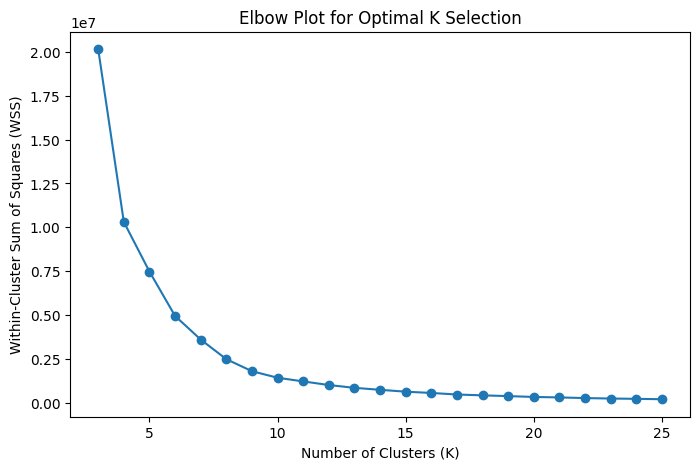

In [87]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [96]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [97]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'relative_value', 'overall_ranking', 'position_rank', 'player_value_tier']]

In [98]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)